In [1]:
!pip install SoccerNet
!pip uninstall wandb -y

import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import cv2
from glob import glob
import re
import yaml

In [2]:
!pip uninstall -y numpy
!rm -rf /usr/local/lib/python3.11/dist-packages/numpy*

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [2]:
!pip install numpy==1.26.4 matplotlib==3.9.2 ultralytics==8.3.33

In [ ]:
import os, sys
os.kill(os.getpid(), 9)
# Run it again

In [3]:
yolo_base = '/kaggle/working/yolov8'
sn_track_base = '/tmp/tracking'

In [4]:
!mkdir -p $sn_track_base
!touch $sn_track_base/test.zip
!touch $sn_track_base/challenge.zip

mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="/tmp/")
mySoccerNetDownloader.downloadDataTask(task="tracking", split=["train", "test", "challenge"])
!unzip -q -d $sn_track_base $sn_track_base/train.zip

/tmp/tracking/train.zip already exists
/tmp/tracking/test.zip already exists
/tmp/tracking/challenge.zip already exists
replace /tmp/tracking/train/SNMOT-060/gt/gt.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
# Of the 57 half , 50 are used for training and 7 for validation.
trn_dirs = sorted(glob(f'{sn_track_base}/train/SNMOT*'))
#tst_dirs = sorted(glob(f'{sn_track_base}/test/SNMOT*'))
tst_dirs = trn_dirs[50:]
trn_dirs = trn_dirs[:50]

debug=True
if debug:
    trn_dirs = trn_dirs[:5]
    tst_dirs = tst_dirs[:5]

split_dirs = {
    'train':trn_dirs,
    'valid':tst_dirs
}

# ４ types of labels are used.
# labels = ['ball', 'player', 'referee', 'goalkeepers']
# label_dict = {'ball': 0, 'player': 1, 'referee': 2, 'goalkeeper': 3, 'goalkeepers': 3}
labels = ['player team left', 'player team right', 'goalkeepers team left', 'goalkeeper team right', 'referee', 'ball']
label_dict = {'player team left' : 0, 'player team right' : 1, 'goalkeepers team left' : 2, 'goalkeeper team right' : 3, 'referee' : 4, 'ball' : 5}

In [7]:
#(1) image file path
yolo_train_img_dir = f'{yolo_base}/images/train'
yolo_valid_img_dir = f'{yolo_base}/images/valid'

#(2) label file path
yolo_train_label_dir = f'{yolo_base}/labels/train'
yolo_valid_label_dir = f'{yolo_base}/labels/valid'

#(3) config file path
yaml_file = f'{yolo_base}/data.yaml'

#!rm -rf /home/tito/kaggle/dfl-bundesliga-data-shootout/work/yolov5
os.makedirs(yolo_train_img_dir, exist_ok=True)
os.makedirs(yolo_valid_img_dir, exist_ok=True)
os.makedirs(yolo_train_label_dir, exist_ok=True)
os.makedirs(yolo_valid_label_dir, exist_ok=True)

In [8]:
# convert from x,y,w,h to yolo format
def get_yolo_format_bbox(img_w, img_h, box):
    w = box[2]
    h = box[3]
    xc = box[0] + int(np.round(w/2))
    yc = box[1] + int(np.round(h/2))
    box = [xc/img_w, yc/img_h, w/img_w, h/img_h]
    box = [f"{i:.4g}" for i in box]
    return box

In [9]:
def get_info(info):
    results = []
    for line in open(info):
        # Match the tracklet ID and capture the full label after '='
        m = re.match(r'trackletID_(\d+)=\s*(.*)', line.strip())
        if m:
            # Extract the full label and split by ';' to get the first part
            label = m.group(2).split(";")[0].strip()
            if label not in label_dict:
                print('bad label:', label)  # Debugging for unmatched labels
                continue 
            # Append the ID and label to the results
            results.append([m.group(1), label])
            print("Processed:", results)  # Debugging processed results
    # Convert results to a DataFrame and return as a dictionary
    return pd.DataFrame(results, columns=['id', 'lbl']).set_index('id').to_dict()['lbl']

In [10]:
# make image simlink and label files
for split in split_dirs:
    if split == 'train':
        yolo_img_dir = yolo_train_img_dir
        yolo_label_dir = yolo_train_label_dir
    else:
        yolo_img_dir = yolo_valid_img_dir
        yolo_label_dir = yolo_valid_label_dir
        
    for this_dir in split_dirs[split]:
        print('this_dir:',this_dir)
        video = this_dir.split('/')[-1]
        info = this_dir + '/gameinfo.ini'
        det = this_dir + '/gt/gt.txt'
        info_dict = get_info(info)
        det_df = pd.read_csv(det, names=['frame','player','x','y','w','h','f1','f2','f3','f4'], usecols=['frame','player','x','y','w','h'])
        det_df['label'] = det_df.player.astype(str).map(info_dict)
        det_df['label_id'] = det_df['label'].map(label_dict)
        # check
        ng_list = list(det_df[det_df.label_id.isnull()].label.unique())
        if len(ng_list)>0:
            #print('ng_list:',ng_list, det_df.dropna().shape, det_df.shape)
            det_df = det_df.dropna()
        for grp, grp_df in det_df.groupby('frame'):
            frame = f'{grp:06}'
            img_file = f'{this_dir}/img1/{frame}.jpg'
            dst_file = f'{yolo_img_dir}/{video}_{frame}.jpg'
            if not os.path.exists(dst_file):
                os.symlink(img_file, dst_file)
                #print(img_file)
            img = cv2.imread(dst_file)
            height, width, _ = img.shape 
            bboxes = []
            for arr in grp_df[['x', 'y', 'w', 'h', 'label_id']].values:
                box = get_yolo_format_bbox(width, height, arr[:4])
                bboxes.append([arr[4]]+box)
            file_name = f'{yolo_label_dir}/{video}_{frame}.txt'
            with open(file_name, 'w') as f:
                for i, bbox in enumerate(bboxes):
                    bbox = [str(i) for i in bbox]
                    str_bbox = ' '.join(bbox)
                    f.write(str_bbox)
                    f.write('\n')

this_dir: /tmp/tracking/train/SNMOT-060
Processed: [['1', 'player team left']]
Processed: [['1', 'player team left'], ['2', 'player team left']]
Processed: [['1', 'player team left'], ['2', 'player team left'], ['3', 'player team right']]
Processed: [['1', 'player team left'], ['2', 'player team left'], ['3', 'player team right'], ['4', 'player team right']]
Processed: [['1', 'player team left'], ['2', 'player team left'], ['3', 'player team right'], ['4', 'player team right'], ['5', 'player team right']]
Processed: [['1', 'player team left'], ['2', 'player team left'], ['3', 'player team right'], ['4', 'player team right'], ['5', 'player team right'], ['6', 'player team right']]
Processed: [['1', 'player team left'], ['2', 'player team left'], ['3', 'player team right'], ['4', 'player team right'], ['5', 'player team right'], ['6', 'player team right'], ['7', 'player team right']]
Processed: [['1', 'player team left'], ['2', 'player team left'], ['3', 'player team right'], ['4', 'play

In [11]:
# Dump config file
data_yaml = dict(
    train = yolo_train_img_dir,
    val = yolo_valid_img_dir,
    nc = 6,
    names = labels
)

with open(yaml_file, 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [12]:
import numpy
print(numpy.__version__)

1.26.4


In [13]:
!pip install ultralytics==8.3.33

In [14]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.33 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6538.3/8062.4 GB disk)


In [15]:
from IPython import display
display.clear_output()

In [16]:
!pip uninstall -y ray

In [17]:
!yolo task=detect mode=train model=yolov8x.pt data={yaml_file} epochs=2 imgsz=600 plots=True

New https://pypi.org/project/ultralytics/8.3.214 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.33 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/yolov8/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=600, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_

In [20]:
# predict!
check_images = f'{tst_dirs[0]}/img1'
weight_file = 'runs/detect/train/weights/best.pt'
!yolo task=detect mode=predict model=$weight_file source=$check_images save=True

Ultralytics 8.3.33 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 68,129,346 parameters, 0 gradients, 257.4 GFLOPs

image 1/750 /tmp/tracking/train/SNMOT-164/img1/000001.jpg: 352x608 6 player team lefts, 1 player team right, 11 referees, 1 ball, 67.3ms
image 2/750 /tmp/tracking/train/SNMOT-164/img1/000002.jpg: 352x608 8 player team lefts, 1 player team right, 10 referees, 1 ball, 34.9ms
image 3/750 /tmp/tracking/train/SNMOT-164/img1/000003.jpg: 352x608 8 player team lefts, 7 referees, 1 ball, 35.5ms
image 4/750 /tmp/tracking/train/SNMOT-164/img1/000004.jpg: 352x608 6 player team lefts, 1 player team right, 1 goalkeeper team right, 8 referees, 1 ball, 35.5ms
image 5/750 /tmp/tracking/train/SNMOT-164/img1/000005.jpg: 352x608 6 player team lefts, 2 player team rights, 7 referees, 1 ball, 35.5ms
image 6/750 /tmp/tracking/train/SNMOT-164/img1/000006.jpg: 352x608 6 player team lefts, 2 player team rights, 7 referees, 35.1ms
image 7/750 /tmp/

In [22]:
!ls runs/detect/predict

000001.jpg  000126.jpg	000251.jpg  000376.jpg	000501.jpg  000626.jpg
000002.jpg  000127.jpg	000252.jpg  000377.jpg	000502.jpg  000627.jpg
000003.jpg  000128.jpg	000253.jpg  000378.jpg	000503.jpg  000628.jpg
000004.jpg  000129.jpg	000254.jpg  000379.jpg	000504.jpg  000629.jpg
000005.jpg  000130.jpg	000255.jpg  000380.jpg	000505.jpg  000630.jpg
000006.jpg  000131.jpg	000256.jpg  000381.jpg	000506.jpg  000631.jpg
000007.jpg  000132.jpg	000257.jpg  000382.jpg	000507.jpg  000632.jpg
000008.jpg  000133.jpg	000258.jpg  000383.jpg	000508.jpg  000633.jpg
000009.jpg  000134.jpg	000259.jpg  000384.jpg	000509.jpg  000634.jpg
000010.jpg  000135.jpg	000260.jpg  000385.jpg	000510.jpg  000635.jpg
000011.jpg  000136.jpg	000261.jpg  000386.jpg	000511.jpg  000636.jpg
000012.jpg  000137.jpg	000262.jpg  000387.jpg	000512.jpg  000637.jpg
000013.jpg  000138.jpg	000263.jpg  000388.jpg	000513.jpg  000638.jpg
000014.jpg  000139.jpg	000264.jpg  000389.jpg	000514.jpg  000639.jpg
000015.jpg  000140.jpg	000265.jpg 

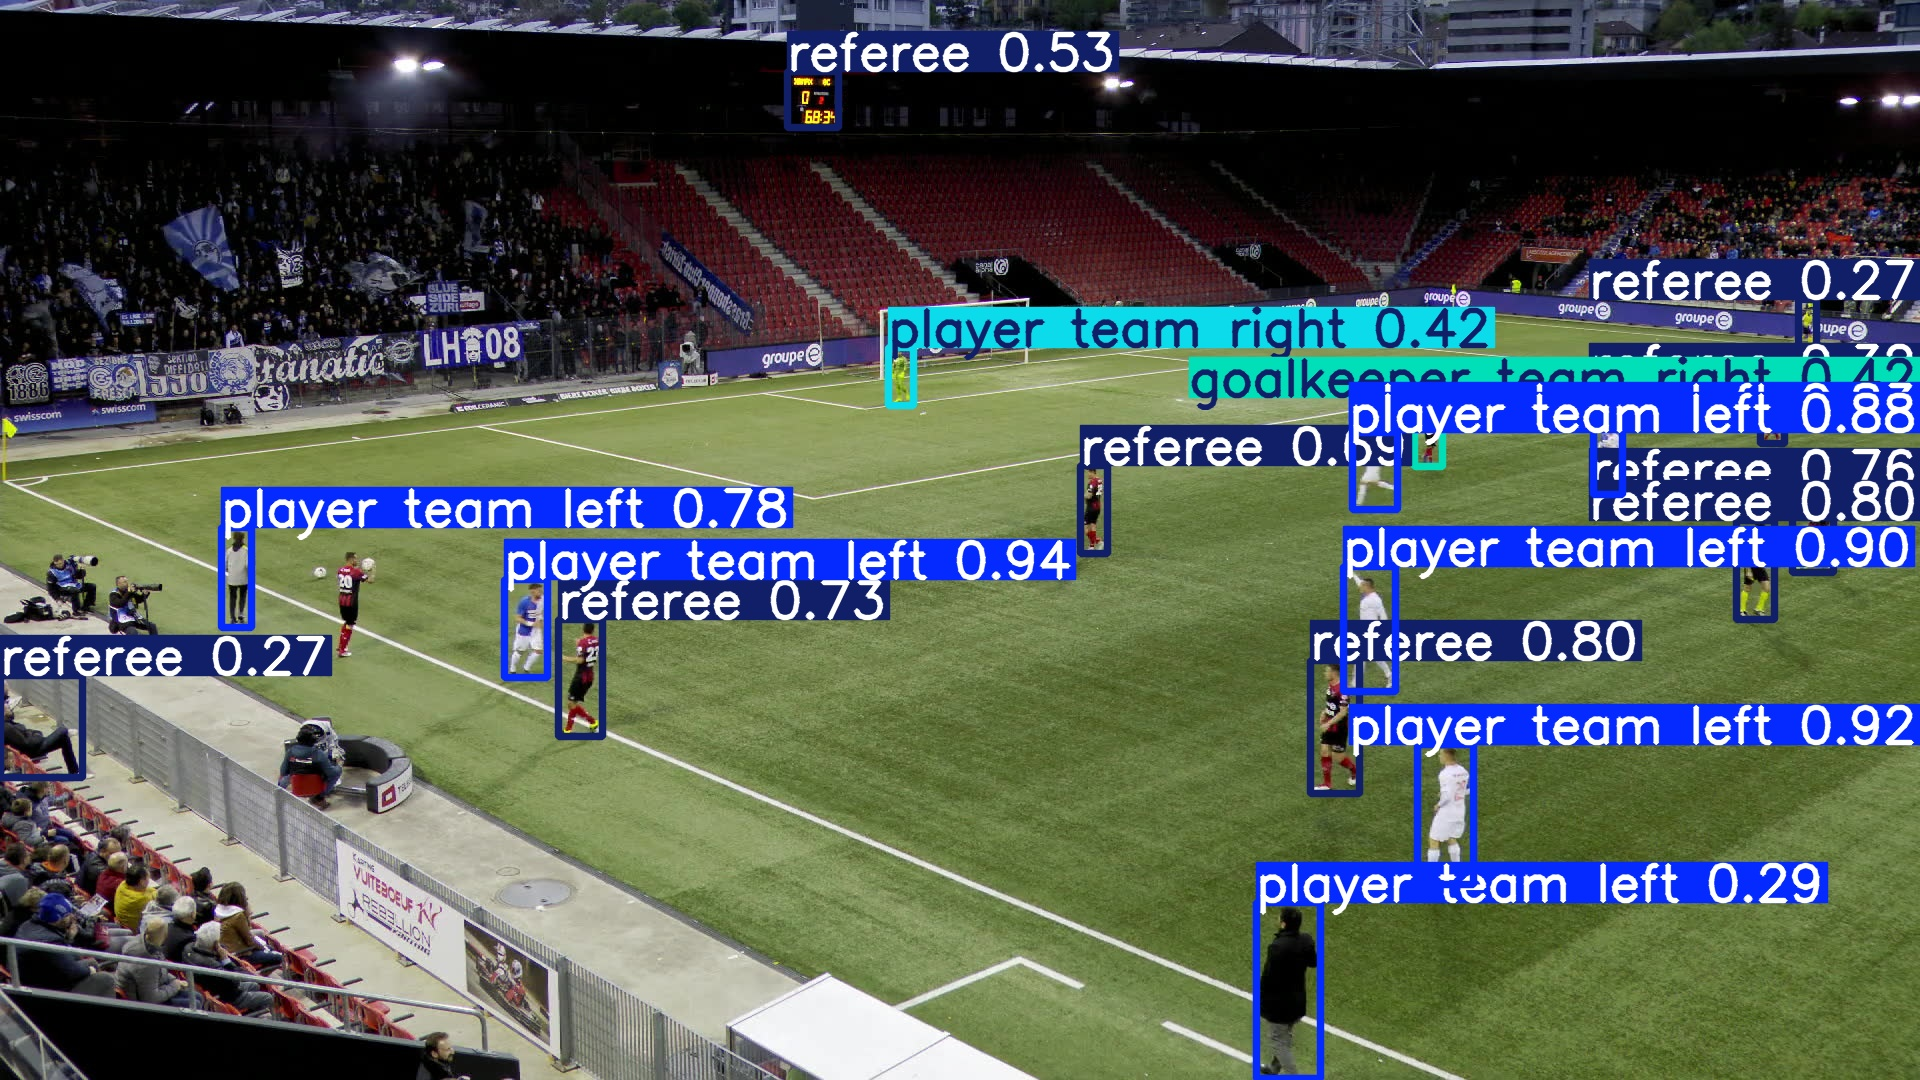

In [23]:
# Check some results. 
Image(f'/kaggle/working/runs/detect/predict/000013.jpg')
# display(Image(f'{yolo_base}/runs/detect/000400.jpg'))